## Seam carving: content aware resizing of images

In [1]:
from PIL import Image
import matplotlib as plt
import requests
from io import BytesIO
import numpy as np

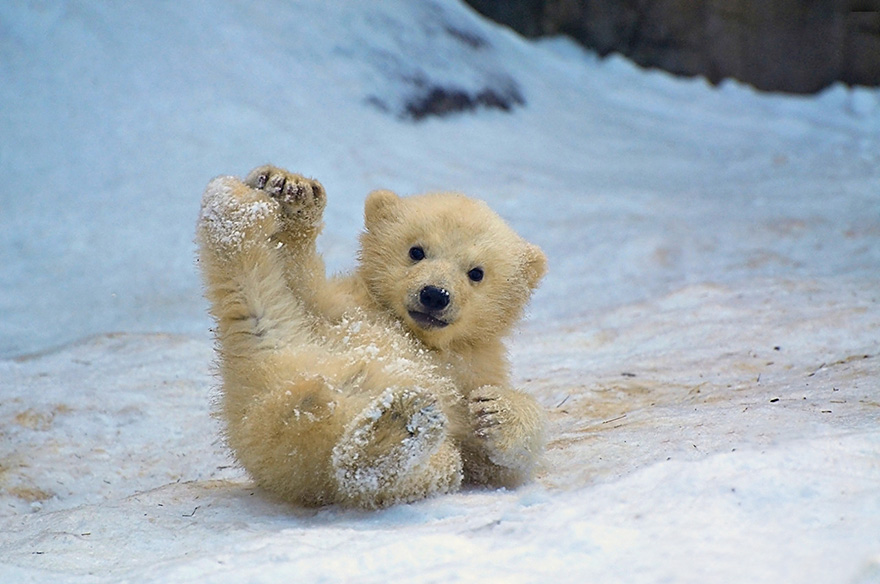

In [226]:
# Let's present an image that we are going to perform seam carving on
img_urls = [
    "https://static.boredpanda.com/blog/wp-content/uploads/2016/02/cute-baby-polar-bear-day-photography-14__880.jpg",
    "https://cdn3.dpmag.com/2019/10/shutterstock_1239834655.jpg",
    "https://images.unsplash.com/photo-1517021897933-0e0319cfbc28?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80",
]
response = requests.get(img_urls[0])
img = Image.open(BytesIO(response.content)).convert('RGB')
img2 = img.copy()

img

In [227]:
img = img.convert('L')
img_arr = np.array(img)
img_arr.shape

(584, 880)

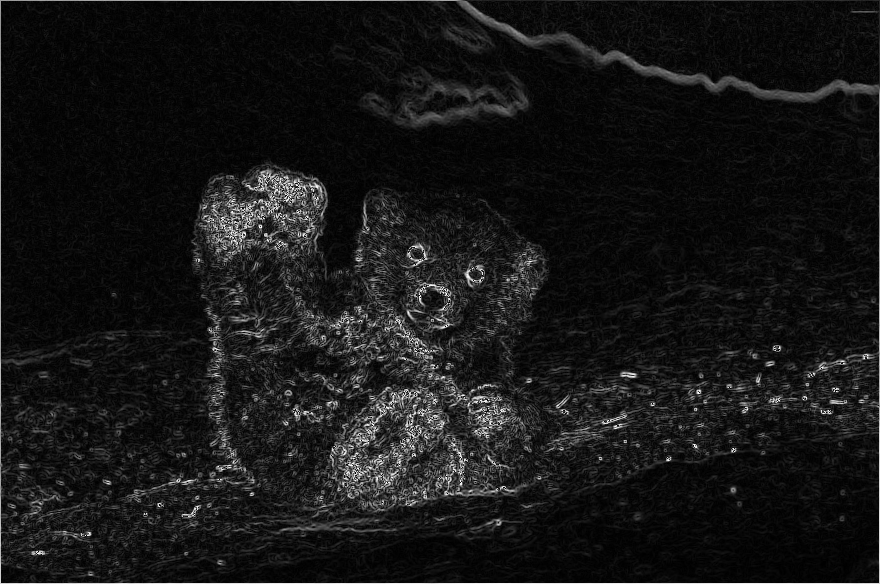

In [228]:
## Create Energy map from the image
## This part may take a minute depending on the size of the image
def convolve(mat):
    x_sobel = np.array([
        [ 1, 1, 1],
        [ 0, 0, 0],
        [-1,-1,-1],
    ])
    
    y_sobel = np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1],
    ])
    
    gx = 0
    gy = 0
    for i in range(3):
        gx += np.dot(mat[i,:],x_sobel[:,i])
        gy += np.dot(mat[i,:],y_sobel[:,i])
    return (gy**2 + gx**2)**(1/2)
    

def energy_map(im_arr):
    energy_arr = im_arr.copy()

    for i in range(1,im_arr.shape[0]-1):
        for j in range(1,im_arr.shape[1]-1):
            pixel_val = convolve(im_arr[i-1:i+2, j-1:j+2])
            energy_arr[i][j] = pixel_val
                    
    return energy_arr    

img_energy = energy_map(img_arr)
Image.fromarray(img_energy)

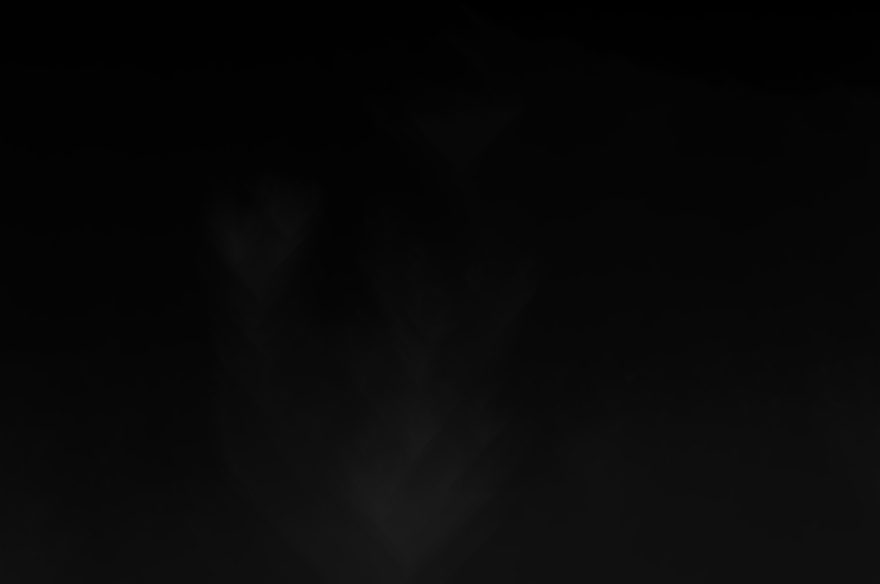

In [229]:
## Now let's create a cost map to find the path that is least important in the image

def createPathMap(energy_map):
    path_map = energy_map.copy().astype('int16')
    
    for i in range(1,path_map.shape[0]):
        for j in range(path_map.shape[1]):
            if j-1 >= 0 and j+1 < path_map.shape[1]:
                path_map[i][j] = path_map[i][j] + min(path_map[i-1][j-1], path_map[i-1][j], path_map[i-1][j+1])
            if j-1 < 0:
                path_map[i][j] = path_map[i][j] + min(path_map[i-1][j], path_map[i-1][j+1])
            if j+1 >= path_map.shape[1]:
                path_map[i][j] = path_map[i][j] + min(path_map[i-1][j-1], path_map[i-1][j])
    return path_map

path_map = createPathMap(img_energy)
Image.fromarray(path_map)

In [230]:
path_map

array([[ 157,  158,  158, ...,   41,   40,   41],
       [ 315,  160,  164, ...,   52,   47,   83],
       [ 317,  164,  168, ...,   70,   53,   89],
       ...,
       [4214, 4009, 4012, ..., 3933, 3932, 4144],
       [4222, 4011, 4015, ..., 3943, 3945, 4139],
       [4224, 4224, 4222, ..., 4156, 4155, 4153]], dtype=int16)

In [231]:
## This is where the path is backtracked

def backtrackForPath(local_path_map):
    local_path_map[local_path_map.shape[0]-1, :].argmin()

    seams = [local_path_map[local_path_map.shape[0]-1, :].argmin()]

    for i in range(local_path_map.shape[0]-1, 0, -1):
        j_index = seams[len(seams)-1]
        if j_index - 1 >= 0 and j_index + 1 < local_path_map.shape[1]:
            seams.append(np.array([local_path_map[i][j_index - 1], 
                            local_path_map[i][j_index], 
                            local_path_map[i][j_index + 1]]).argmin()-1+j_index)
        if j_index - 1 < 0:
            seams.append(np.array([
                            local_path_map[i][j_index], 
                            local_path_map[i][j_index + 1]]).argmin()-1+j_index)
        if j_index + 1 >= local_path_map.shape[1]:
            seams.append(np.array([local_path_map[i][j_index - 1], 
                            local_path_map[i][j_index]]).argmin()-1+j_index)
            
    return seams

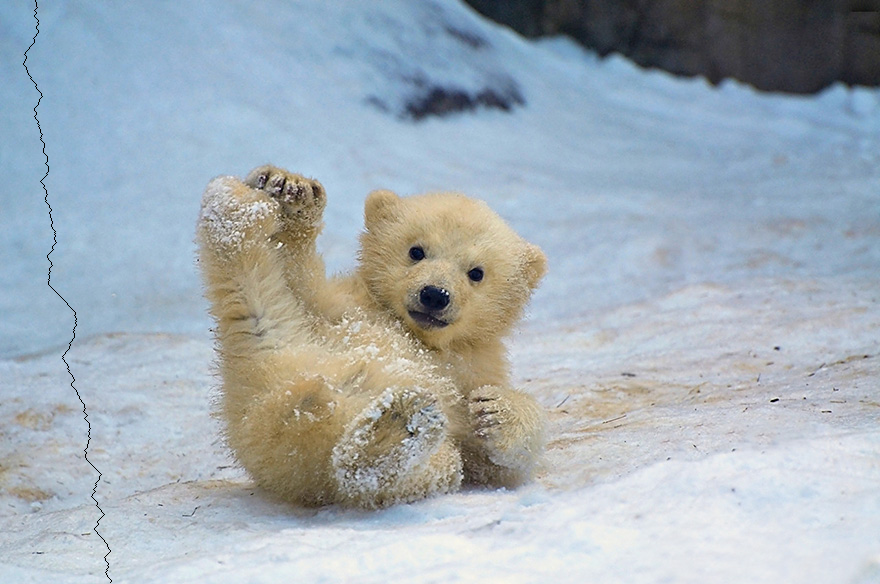

In [232]:
#Now we found a seam, lets display it on img2
img2_arr = np.array(img2)
seams = backtrackForPath(path_map)

for i in range(len(img2_arr)-1):
    img2_arr[i][seams.pop()] = [0,0,0]
    
Image.fromarray(img2_arr)

In [233]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

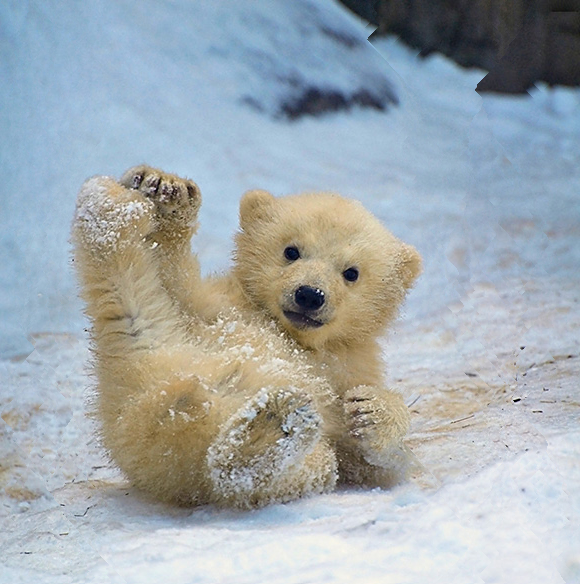

In [234]:
def excludeSeam(img_aslist, energy_aslist, col_indexes):
    for i in range(0, len(img_aslist)): 
        col_index = col_indexes.pop()
        del img_aslist[i][col_index]
        del energy_aslist[i][col_index]

def excludeNSeams(n=300):
    new_img_list = img2_arr.tolist()
    new_img_energy_list = img_energy.tolist()

    for i in range(n):
        path_map = createPathMap(np.array(new_img_energy_list, dtype=np.uint8))
        seam = backtrackForPath(path_map)
        excludeSeam(new_img_list,new_img_energy_list, seam)
        
    array = np.array(new_img_list, dtype=np.uint8)
    return Image.fromarray(array)

excludeNSeams()

## Potential Improvments:
### -  Add Forward Energy 
### - Optimize Algorithms
### - Add audience-interaction with images/notebook
### - Refactor